# Определение стоимости автомобилей

**Описание проекта**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

Данные находятся в файле `/datasets/autos.csv`.

В файле имеются следующие признаки:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя
- `Price` — цена (евро)


**План проекта**

1. Загрузить файл
2. Провести предварительный обзор данных;
3. Провести предобработку данных;
4. Провести исследовательский анализ данных;
5. Провести корреляционный анализ;
6. Построить и проанализировать модели машинного обучения1;
7. Сделать выводы.

## Загрузка файлов

In [1]:
!pip install phik -q

In [2]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import warnings

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import (
    r2_score,
    mean_squared_error, 
    mean_absolute_error)

warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

RANDOM_STATE = 42
LOCAL_PATH = '/datasets/autos.csv'
REMOTE_PATH = 'https://code.s3.yandex.net/datasets/autos.csv'

In [3]:
try:
    autos = pd.read_csv(LOCAL_PATH, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
except:
    autos = pd.read_csv(REMOTE_PATH, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

##  Обзор данных

### Датасет `autos`

In [4]:
def get_info(data):
    display(data.head())
    data.info()
    display(data.describe().T)

In [5]:
get_info(autos)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


### Вывод

В ходе предварительного анализа можно сделать следующие выводы:
- Датасет `autos`:
    - Всего в датасете 354369 строк и 15 столбцов;
    - Необходимо привести названия к единому стилю;
    - Явные пропуски обнаружены в столбцах:
        - `VehicleType`;
        - `Gearbox`;
        - `Model`;
        - `FuelType`;
        - `Repaired`.
    - Типы данных в столбцах оптимальные;
    - Необходимо проверить данные на дубликаты;
    - Обнаружены явные выбросы в столбцах:
        - `RegistrationYear`;
        - `Power`.
    - В столбце `number_of_pictures` все значения равны 0, поэтому необходимость в данном столбце отпадает, удалим его.
        
Данные являются пригодными для исследования.

## Предобработка данных

In [6]:
autos.drop('NumberOfPictures', axis=1, inplace=True)

### Названия столбцов

In [7]:
autos = autos.reindex(columns=['Brand', 'Model', 'VehicleType', 'Gearbox', 'Power',  'FuelType', 'Kilometer',
                         'RegistrationYear', 'RegistrationMonth', 'Repaired', 'Price',
                         'DateCreated', 'DateCrawled', 'LastSeen', 'PostalCode'])
autos.head()

,Brand,Model,VehicleType,Gearbox,Power,FuelType,Kilometer,RegistrationYear,RegistrationMonth,Repaired,Price,DateCreated,DateCrawled,LastSeen,PostalCode
0,volkswagen,golf,NaN,manual,0,petrol,150000,1993,0,NaN,480,2016-03-24,2016-03-24 11:52:17,2016-04-07 03:16:57,70435
1,audi,NaN,coupe,manual,190,gasoline,125000,2011,5,yes,18300,2016-03-24,2016-03-24 10:58:45,2016-04-07 01:46:50,66954
2,jeep,grand,suv,auto,163,gasoline,125000,2004,8,NaN,9800,2016-03-14,2016-03-14 12:52:21,2016-04-05 12:47:46,90480
3,volkswagen,golf,small,manual,75,petrol,150000,2001,6,no,1500,2016-03-17,2016-03-17 16:54:04,2016-03-17 17:40:17,91074
4,skoda,fabia,small,manual,69,gasoline,90000,2008,7,no,3600,2016-03-31,2016-03-31 17:25:20,2016-04-06 10:17:21,60437


In [8]:
autos.columns = autos.columns.str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True).str.lower()
autos.columns

Index(['brand', 'model', 'vehicle_type', 'gearbox', 'power', 'fuel_type',
       'kilometer', 'registration_year', 'registration_month', 'repaired',
       'price', 'date_created', 'date_crawled', 'last_seen', 'postal_code'],
      dtype='object')

### Пропуски в данных

Рассмотрим сколько точно пропусков и в каких столбцах у нас имеется и затем решим, как можно избавиться от пропусков.

In [9]:
autos.isna().sum()

brand                     0
model                 19705
vehicle_type          37490
gearbox               19833
power                     0
fuel_type             32895
kilometer                 0
registration_year         0
registration_month        0
repaired              71154
price                     0
date_created              0
date_crawled              0
last_seen                 0
postal_code               0
dtype: int64

Узнаем какую долю от общих данных составляют пропуски и насколько важную роль они играют в общей картине данных.

In [10]:
autos.isna().sum() / len(autos)

brand                 0.000000
model                 0.055606
vehicle_type          0.105794
gearbox               0.055967
power                 0.000000
fuel_type             0.092827
kilometer             0.000000
registration_year     0.000000
registration_month    0.000000
repaired              0.200791
price                 0.000000
date_created          0.000000
date_crawled          0.000000
last_seen             0.000000
postal_code           0.000000
dtype: float64

Пропуски в данных столлбцах занимают значительную долю записей, поэтому удалять их не вариант. Проверим каким значением можно заменить пропуски в данном столбце, начав с анализа имеющихся категорий.

Варианты заполнения пропусков:
1. Заполнить пропуски на основе имеющихся данных (точный, но затратный по ресурсам способ);
2. Заполнить пропуски значением `unknown` (быстрый способ).

В результате был выбран второй способ, потому что первый способ занял слишком много времени на выполнение, и он не покроет все пропуски, а заказчику важна скорость.

In [11]:
autos.fillna('unknown', inplace=True)
autos.isna().sum()

brand                 0
model                 0
vehicle_type          0
gearbox               0
power                 0
fuel_type             0
kilometer             0
registration_year     0
registration_month    0
repaired              0
price                 0
date_created          0
date_crawled          0
last_seen             0
postal_code           0
dtype: int64

Однако в столбце `repaired` все не так однозначно: если в нем данные неизвестны, можно предположить два варианта:
1. Ремонта не было, поэтому не указали;
2. Ремонт был, но продавец захотел сокрыть эту информацию.

Данная несостыковка возникла из-за возможности не указывать в анкете вариантов, вероятно, стоит изменить бланк анкеты. Будем считать, что если в столбце `repaired` значение неизвестно, значит, автомобиль был в ремонте.

In [12]:
autos['repaired'].value_counts()

no         247161
unknown     71154
yes         36054
Name: repaired, dtype: int64

In [13]:
autos['repaired'] = autos['repaired'].replace('unknown', 'yes')
autos['repaired'].value_counts()

no     247161
yes    107208
Name: repaired, dtype: int64

### Дубликаты в данных

#### Явные дубликаты

In [14]:
autos.duplicated().sum()

4

In [15]:
autos.drop_duplicates(inplace=True)
autos.duplicated().sum()

0

#### Неявные дубликаты

Неявные дубликаты проверим во всем столбцам с категориальными данными.

In [16]:
cat_cols = autos.select_dtypes('object').columns
cat_cols

Index(['brand', 'model', 'vehicle_type', 'gearbox', 'fuel_type', 'repaired'], dtype='object')

In [17]:
for col in cat_cols:
    print(f'Уникальные занчения в столбце {col}: {autos[col].unique()}\n')
    display(autos[col].value_counts())

Уникальные занчения в столбце brand: ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']



volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2322
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: brand, dtype: int64

Уникальные занчения в столбце model: ['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster

golf                  29232
other                 24420
3er                   19761
unknown               19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 251, dtype: int64

Уникальные занчения в столбце vehicle_type: ['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']



sedan          91457
small          79830
wagon          65165
unknown        37490
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

Уникальные занчения в столбце gearbox: ['manual' 'auto' 'unknown']



manual     268249
auto        66283
unknown     19833
Name: gearbox, dtype: int64

Уникальные занчения в столбце fuel_type: ['petrol' 'gasoline' 'unknown' 'lpg' 'other' 'hybrid' 'cng' 'electric']



petrol      216349
gasoline     98719
unknown      32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

Уникальные занчения в столбце repaired: ['yes' 'no']



no     247158
yes    107207
Name: repaired, dtype: int64

Наблюдается совпадение названий моделей `rangerover` и `range_rover`, сделаем для них общее название `range_rover`.

In [18]:
autos['model'] = autos['model'].replace('rangerover', 'range_rover')
autos['model'].unique()

array(['golf', 'unknown', 'grand', 'fabia', '3er', '2_reihe', 'other',
       'c_max', '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo',
       'a_klasse', 'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo',
       'corsa', 'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra',
       'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter',
       '156', 'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'a1',
       'insignia', 'combo', 'focus', 'tt', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', '100', 'z_reihe', 'sportage', 'sorento', 'v40',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe',
       'espace', 'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus',

Также наблюдаются дубликаты в столбце вида топлива: *petrol* и *gasoline*. Это одно и тоже, бензин, просто название в разных странах.

In [19]:
autos['fuel_type'] = autos['fuel_type'].replace('gasoline', 'petrol')
autos['fuel_type'].unique()

array(['petrol', 'unknown', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

### Выбросы в данных

In [20]:
def num_hist_box(data, feature):
    fig, (ax_main, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.6, .4)})
    fig.set_size_inches((20, 7))
    sns.histplot(x=data[feature], kde=True, discrete=True, ax=ax_main).set(ylabel='Количество')
    sns.boxplot(x=data[feature], ax=ax_box)
    plt.suptitle(f'График распределения {feature}', size=16)
    plt.xlabel(f'Значения {feature}')
    plt.show()

#### Столбец `registration_year`

Выбросы в данном столбце можно объяснить тем, что в анкете ограничение на ввод года есть от 1000 до 9999, что странно для автомобиля. Рассмотрим год следующим образом, первая регстрация в России стала возможна с 1900 года, примем его минимальным, максимальным примем 2016, так как максимальная дата скачивания анкеты это 4 месяц 2016 год.

In [21]:
autos['date_crawled'].describe()

count                  354365
unique                 271174
top       2016-03-24 14:49:47
freq                        7
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: date_crawled, dtype: object

In [22]:
autos = autos.query('registration_year > 1900 & registration_year <= 2016 & registration_month < 4')
autos['registration_year'].describe()

count    109821.000000
mean       2001.780488
std           8.012793
min        1910.000000
25%        1998.000000
50%        2002.000000
75%        2006.000000
max        2016.000000
Name: registration_year, dtype: float64

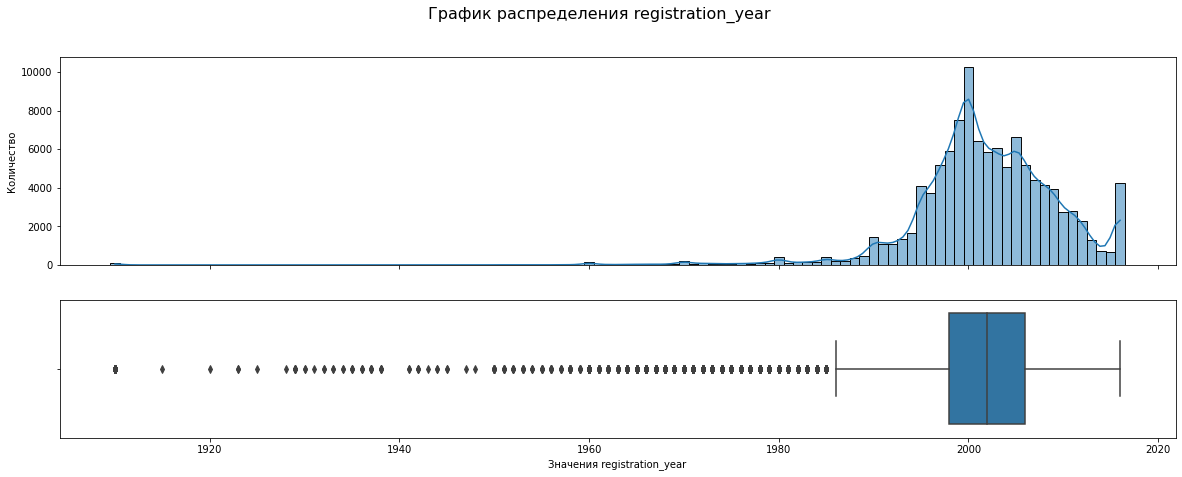

In [23]:
num_hist_box(autos, 'registration_year')

Все равно наблюдается перекос распределения, поэтому удалим все занчения ниже IQR.

In [24]:
def find_IQR(data, feature):
    Q1, Q3 = data[feature].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    return Q1-IQR, Q3+IQR

In [25]:
find_IQR(autos, 'registration_year')

(1990.0, 2014.0)

Удалим все значения ниже 1991 года.

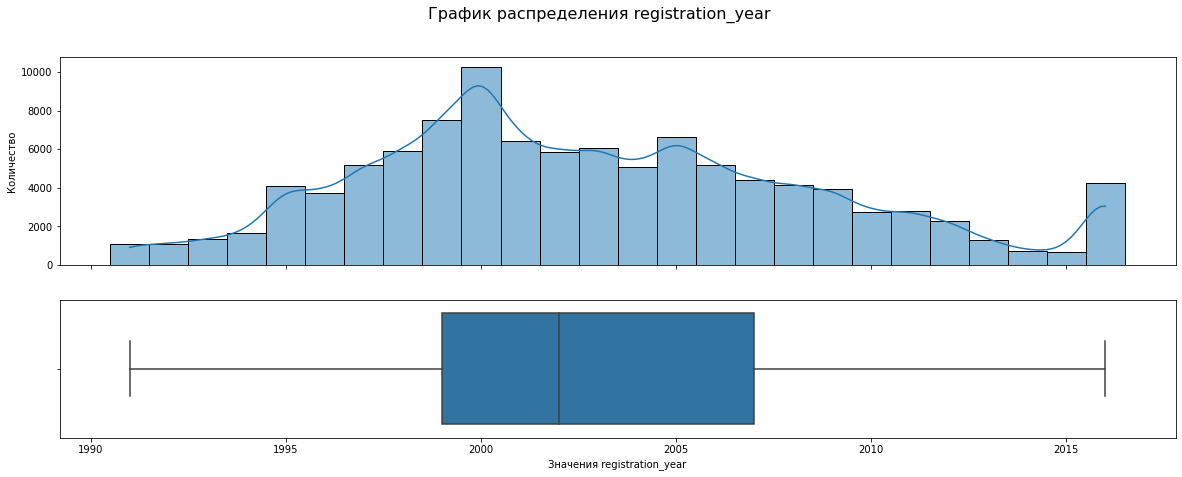

In [26]:
autos = autos.query('registration_year >= 1991')
num_hist_box(autos, 'registration_year')

#### Столбец `power`

В столбце мощности выбросы можно объяснить также технической ошибкой заполнения анкеты, удалим все значения больше 520 л.с., так как на момент 2016 года одним из самых мощных автомобилей был [Audi R8](https://ru.wikipedia.org/wiki/Audi_R8).

Самым маломощным для 90-х годов был найден [Citroën_BX](https://ru.wikipedia.org/wiki/Citroën_BX) с мощностью двигателя 55 л.с.

Таким образом в качестве минимума и максимума возьмем 55 и 525 л.с. соответственно.

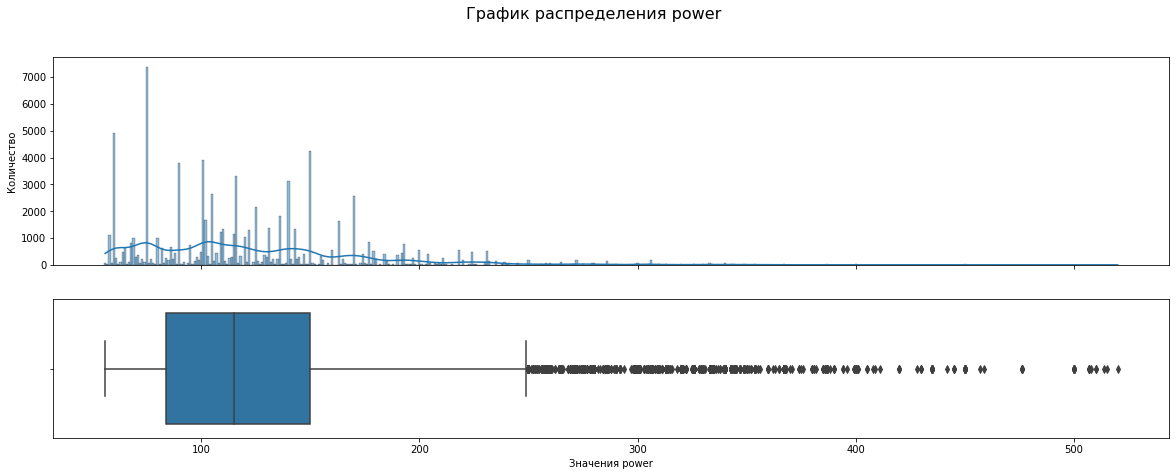

In [27]:
autos = autos.query('power > 55 & power < 525')
num_hist_box(autos, 'power')

Все еще наблюдается множество выбросов, логично предположить, что мощность у LandCruiser и маленького французского хэтчбека будет сильно разниться, поэтому проведем анализ мощность для разных типов кузова.

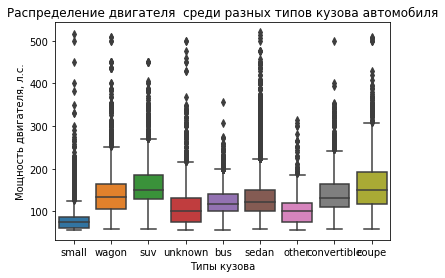

In [28]:
sns.boxplot(data=autos, x='vehicle_type', y='power')
plt.title('Распределение двигателя  среди разных типов кузова автомобиля')
plt.ylabel('Мощность двигателя, л.с.')
plt.xlabel('Типы кузова');

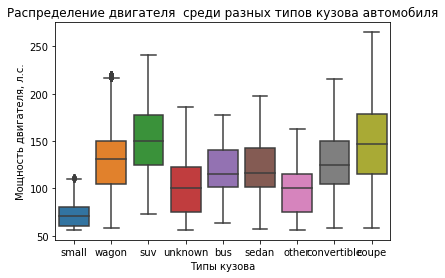

In [29]:
for body_type in autos['vehicle_type'].unique():
    query_df = autos.query('vehicle_type == @body_type')
    iqr_border_1, iqr_border_2 = find_IQR(query_df,'power')
    
    delete_index = autos[(autos['vehicle_type'] == body_type) &
                      ((autos['power'] <= iqr_border_1) |
                       (autos['power'] >= iqr_border_2))].index
    autos.drop(delete_index, inplace=True)

sns.boxplot(data=autos, x='vehicle_type', y='power')
plt.title('Распределение двигателя  среди разных типов кузова автомобиля')
plt.ylabel('Мощность двигателя, л.с.')
plt.xlabel('Типы кузова');

Проверим общую картину с выбросами мощности.

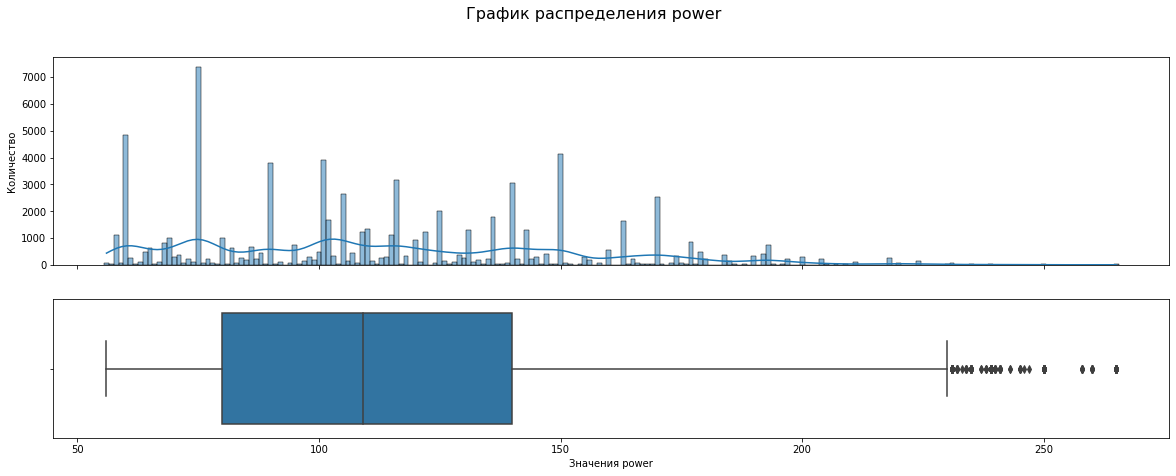

In [30]:
num_hist_box(autos, 'power')

### Вывод

В ходе предобработки данных были проделаны следующие шаги:
 - Названия столбцов приведены к общему стилю;
 - Обработаны пропуски в данных, заменены на `unknown`;
 - Удалены явные дубликаты в данных;
 - Обработаны неявные дубликаты в данных;
 - Обработаны выбросы в данных;
 - Большая часть проблем с данными, вероятно, была вызвана неверным заполнением анкеты:
     - В ней не было обязательных полей;
     - Нет ограничения на некоторые поля, например год;
     - Список вариантов не предлагает варианты выбора, например, модель автомобиля.

## Исследовательский анализ данных

Проведем исследовательский анализ данных и проверим распределение признаков.

In [31]:
def cat_barplot(data, feature, count_rows):
    df_1 = pd.DataFrame(data[feature].value_counts().sort_values(ascending=False))
    other = 0
    for i in range(len(df_1) - count_rows):
        other += int(df_1.iloc[i + count_rows])
    df_1 = df_1.head(count_rows)
    if other != 0:
        df_1.loc['other'] = other
    display(df_1)
    
    ax = sns.barplot(data=df_1, x=df_1.index, y=df_1[feature])
    ax.set(
        title=f'Распределение признака {feature} в тренировочной выборке',
        xlabel=f'Значение {feature}',
        ylabel=f'Количество {feature}')

### Столбец `brand`

,brand
volkswagen,16315
opel,9102
bmw,7759
audi,6189
ford,6034
other,30054


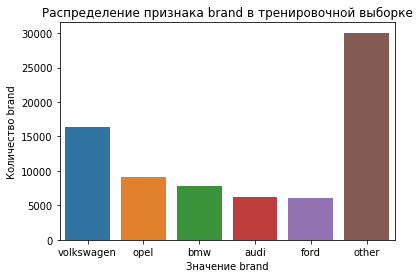

In [32]:
cat_barplot(autos, 'brand', 5)

**Вывод**

Наиболее популярными брендами автомобилей являются:
- Volkswagen;
- Opel;
- BMW;
- Mercedes Benz;
- Audi.

### Столбец `model`

,model
golf,6694
other,53113
3er,4566
unknown,3592
astra,2840


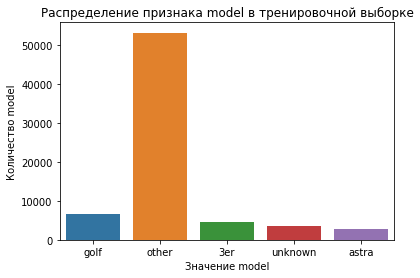

In [33]:
cat_barplot(autos, 'model', 5)

**Вывод**

Наиболее популярными моделями автомобилей являются:
- golf (Volkswagen);
- 3er (BMW);
- astra (Opel).

### Столбец `vehicle_type`

,vehicle_type
sedan,20873
wagon,16221
small,15893
bus,6694
unknown,4432
other,11340


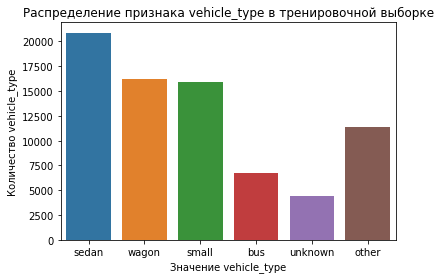

In [34]:
cat_barplot(autos, 'vehicle_type', 5)

**Вывод**

Наиболее популярными типами кузова являются:
- sedan;
- wagon;
- small;
- bus.

### Столбец `gearbox`

,gearbox
manual,61507
auto,11815
other,2131


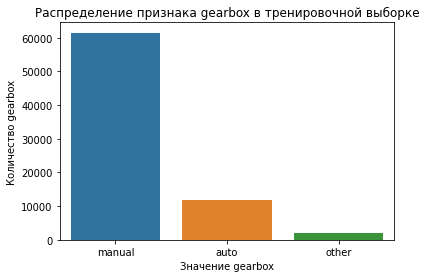

In [35]:
cat_barplot(autos, 'gearbox', 2)

**Вывод**

Наиболее популярными КПП являются:
- Manual (208k);
- Auto (45k).

### Столбец `power`

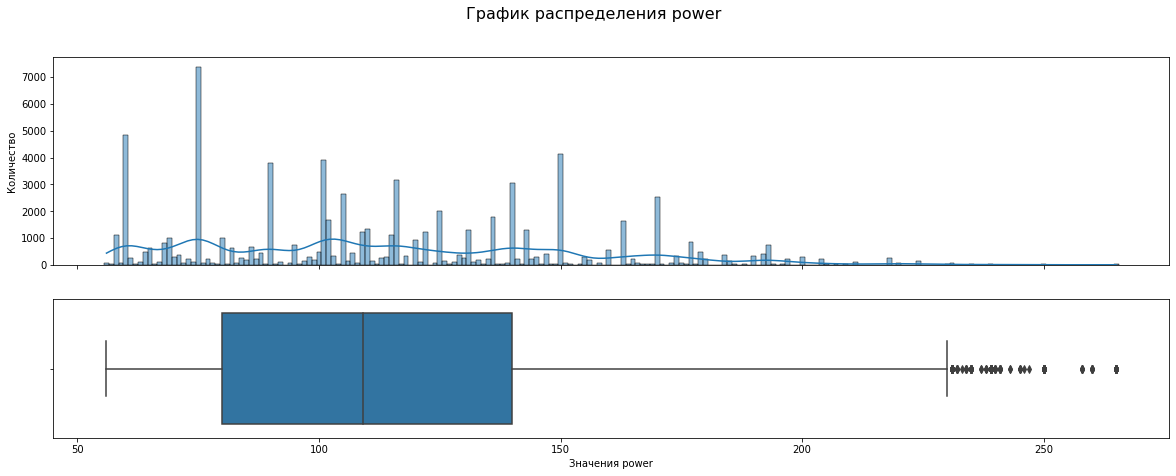

In [36]:
num_hist_box(autos, 'power')

**Вывод**

Мощность автомобиля равномерно распределена на всем промежутке, и имеет следующие характеристики:
- Среднее значение - 117 л.с;
- Медианное значение - 110 л.с;
- Мода - 75 л.с.

### Столбец `fuel_type`

,fuel_type
petrol,68131
unknown,6057
other,1265


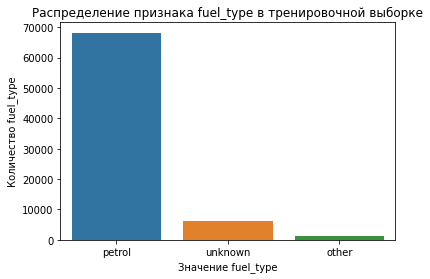

In [37]:
cat_barplot(autos, 'fuel_type', 2)

**Вывод**

Наиболее популярными типами топлива являются:
- Petrol (158k);
- Gasoline (81k).

### Столбец `kilometer`

Для удобства работы и скорости вычислений переведем километры в тыс. км.

In [38]:
autos['kilometer_ths'] = autos['kilometer'] / 1000
autos.drop('kilometer', axis=1, inplace=True)

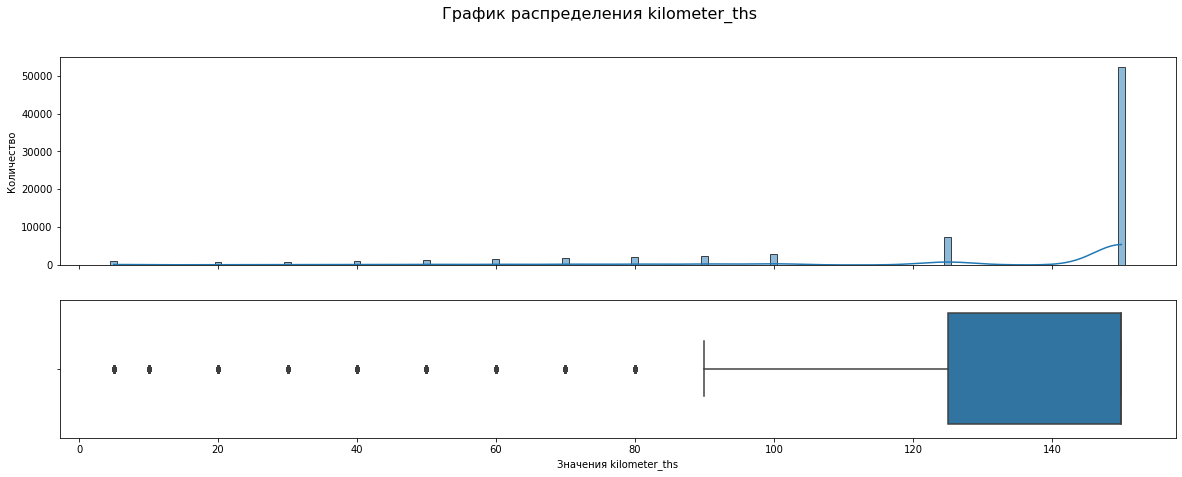

In [39]:
num_hist_box(autos, 'kilometer_ths')

**Вывод**

Замечено, что наиболее часто встречающимся значением является 150 тыс.км, оно же является максимальным, остальных значений крайне мало.

### Столбец `registration_year`

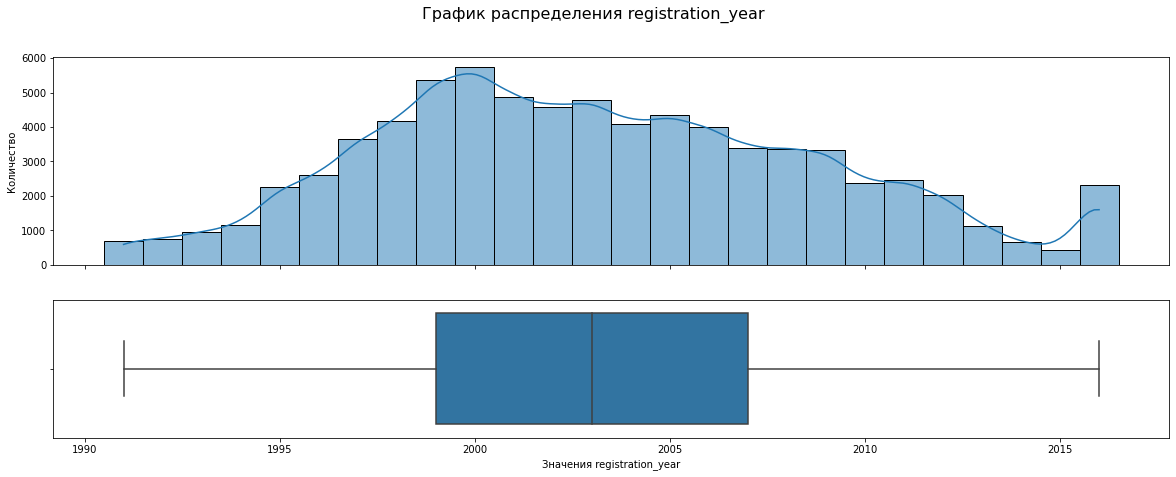

In [40]:
num_hist_box(autos, 'registration_year')

**Вывод**

Большая часть автомобилей зарегистрирована в годы c 1999 по 2007.

### Столбец `registration_month`

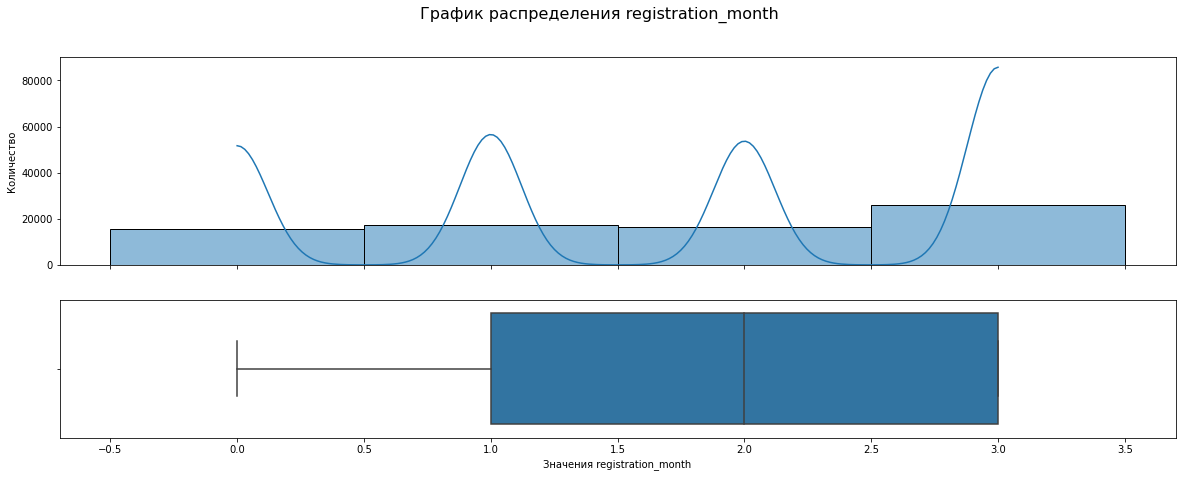

In [41]:
num_hist_box(autos, 'registration_month')

**Вывод**

Месяцы регистрации распределены равномерно по году.

### Столбец `repaired`

,repaired
no,52229
yes,23224


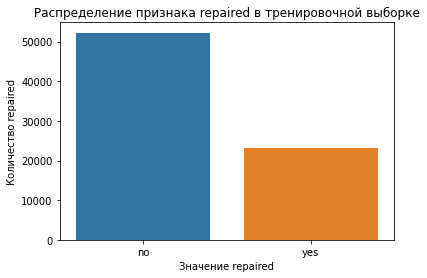

In [42]:
cat_barplot(autos, 'repaired', 2)

**Вывод**

Даже не смотря на то, что неизвестные значения были заменены на наличие ремонта, отстутствие ремонта имеетбольшее число (195 тыс. против 62 тыс.)

### Столбец `price`

Поделим цену так же на 1000 для удобства работы.

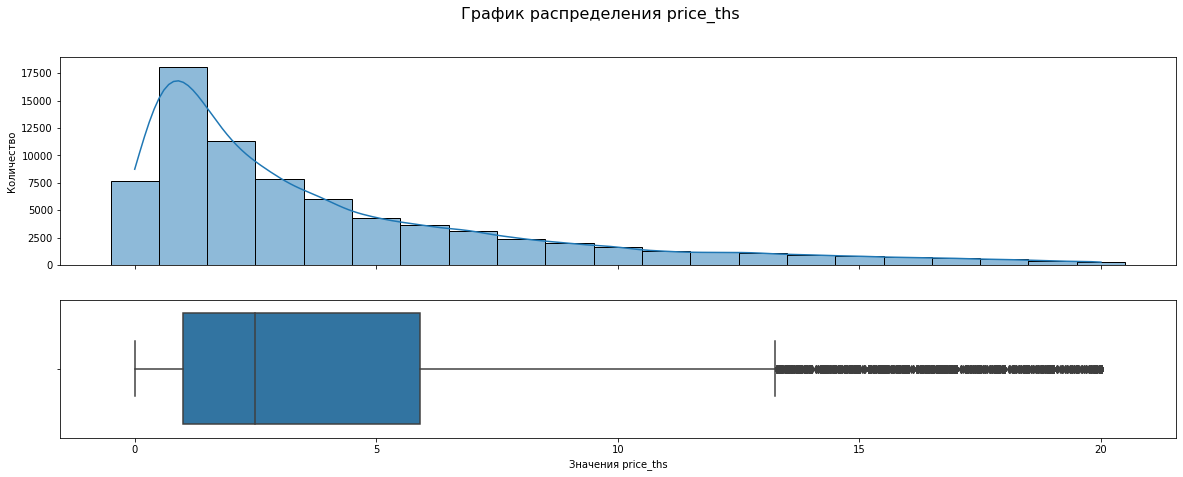

In [43]:
autos['price_ths'] = autos['price'] / 1000
autos.drop(columns='price', inplace=True)
num_hist_box(autos, 'price_ths')

Наблюдается нулевая цена автомобилей, это может означать следующее:
1. Продавец хочет торговаться с покупателем;
2. Продавец хочет отдать автомобиль бесплатно;
3. Продавец забыл указать цену или произошла техническая ошибка.

Поскольку это является  целевым признаком, необходимо исключить из выборки аномально дешевые автомобили, которые стоят дешевле 100 евро.

In [44]:
autos = autos.query('price_ths > 0.1')
autos['price_ths'].describe()

count    72666.000000
mean         4.292760
std          4.272645
min          0.101000
25%          1.199000
50%          2.700000
75%          5.999000
max         20.000000
Name: price_ths, dtype: float64

**Вывод**

Цена автомобиля была приведена к виду тыс. евро. Целевой признак имеет следующие характеристики:
- Среднее значение - 4.75 тыс. евро;
- Медианное значение - 3.2 тыс. евро;
- Максимальное значение - 20 тыс. евро;
- Такую разницу между средним и медианным значениями можно объяснить наличием выбросов в виде высоких цен, однако мы не можем от них избавиться, потому что это является нормой для данной специфики.

Изучать остальные данные не имеет смысла, поскольку даты и почтовый индекс не имеют отношения к автомобилю, от них можно избавиться.

In [45]:
autos.drop(columns=['date_created', 'date_crawled', 'last_seen', 'postal_code'], inplace=True)
autos.head()

,brand,model,vehicle_type,gearbox,power,fuel_type,registration_year,registration_month,repaired,kilometer_ths,price_ths
9,volkswagen,golf,small,manual,101,unknown,1998,0,yes,150.0,0.999
13,volkswagen,passat,wagon,manual,131,unknown,2004,2,no,150.0,2.500
14,nissan,navara,suv,manual,190,petrol,2011,3,no,70.0,17.999
16,volkswagen,polo,unknown,unknown,60,petrol,2016,0,yes,150.0,0.300
17,renault,twingo,small,auto,75,petrol,2004,2,no,150.0,1.750


### Вывод

В ходе исследовательского анализа были сделаны следующие выводы:
- Признак `brand`. Наиболее популярными брендами автомобилей являются:
    - Volkswagen;
    - Opel;
    - BMW;
    - Mercedes Benz;
    - Audi.
- Признак `model`. Наиболее популярными моделями автомобилей являются:
    - golf (Volkswagen);
    - 3er (BMW);
    - astra (Opel).
- Признак `vehicle_type`. Наиболее популярными типами кузова являются:
    - sedan;
    - wagon;
    - small;
    - bus.
- Признак `gearbox`. Наиболее популярными КПП являются:
    - Manual (208k);
    - Auto (45k).
- Пиризнак `power`. Мощность автомобиля равномерно распределена на всем промежутке, и имеет следующие характеристики:
    - Среднее значение - 117 л.с;
    - Медианное значение - 110 л.с;
    - Мода - 75 л.с.
- Признак `fuel_type`. Наиболее популярными типами топлива являются:
    - Petrol (158k);
    - Gasoline (81k).
- Признак `kilometer_ths`. Замечено, что наиболее часто встречающимся значением является 150 тыс.км, оно же является максимальным, остальных значений крайне мало.
- Признак `registration_year`. Большая часть автомобилей зарегистрирована в годы c 1999 по 2007.
- Признак `registration_month`. Месяцы регистрации распределены равномерно по году.
- Признак `reapired`. Даже не смотря на то, что неизвестные значения были заменены на наличие ремонта, отстутствие ремонта имеетбольшее число (195 тыс. против 62 тыс.).
- Признак `price_ths`. Цена автомобиля была приведена к виду тыс. евро. Целевой признак имеет следующие характеристики:
    - Среднее значение - 4.75 тыс. евро;
    - Медианное значение - 3.2 тыс. евро;
    - Максимальное значение - 20 тыс. евро;
    - Такую разницу между средним и медианным значениями можно объяснить наличием выбросов в виде высоких цен, однако мы не можем от них избавиться, потому что это является нормой для данной специфики.

## Корреляционный анализ

Перед созданием моделей машинного обучения необходимо провести корреляционный анализ, чтобы выяснить с чем коррелирует целевой признак и есть ли линейно-зависимые переменные.

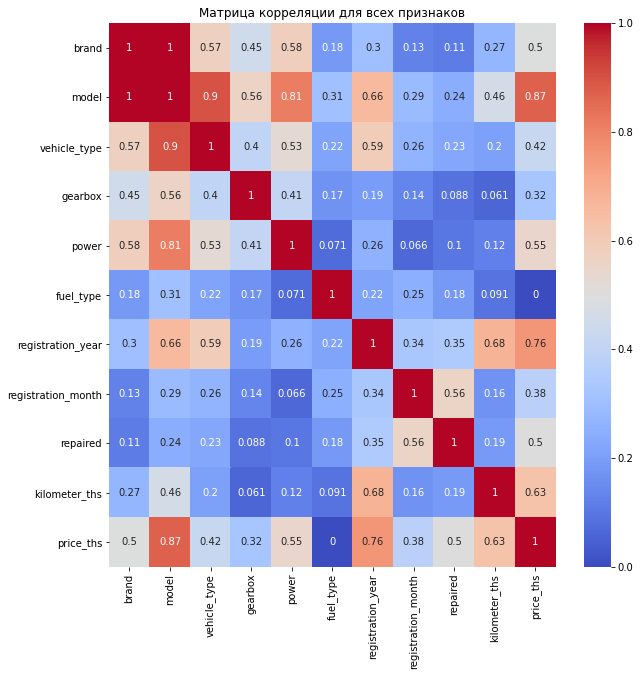

CPU times: user 26.1 s, sys: 718 ms, total: 26.9 s
Wall time: 26.9 s


In [46]:
%%time
#Матрица корреляции со всеми признаками
plt.figure(figsize=(10, 10))
sns.heatmap(autos
    .phik_matrix(interval_cols=[
        'power',
        'kilometer',
        'price']),
        annot=True, 
        cmap='coolwarm')
plt.title('Матрица корреляции для всех признаков')
plt.show();

Наблюдается весьма высокая корреляция бренда и модели автомобиля, избавимся от нее путем объединения в один столбец.

In [47]:
autos['brand_model'] = autos['brand'] + '_' + autos['model']
autos = autos.reindex(columns=[
    'brand_model',
    'vehicle_type',
    'gearbox',
    'power',
    'fuel_type',
    'kilometer_ths',
    'registration_year',
    'registration_month',
    'repaired',
    'price_ths'])
autos.head()

,brand_model,vehicle_type,gearbox,power,fuel_type,kilometer_ths,registration_year,registration_month,repaired,price_ths
9,volkswagen_golf,small,manual,101,unknown,150.0,1998,0,yes,0.999
13,volkswagen_passat,wagon,manual,131,unknown,150.0,2004,2,no,2.500
14,nissan_navara,suv,manual,190,petrol,70.0,2011,3,no,17.999
16,volkswagen_polo,unknown,unknown,60,petrol,150.0,2016,0,yes,0.300
17,renault_twingo,small,auto,75,petrol,150.0,2004,2,no,1.750


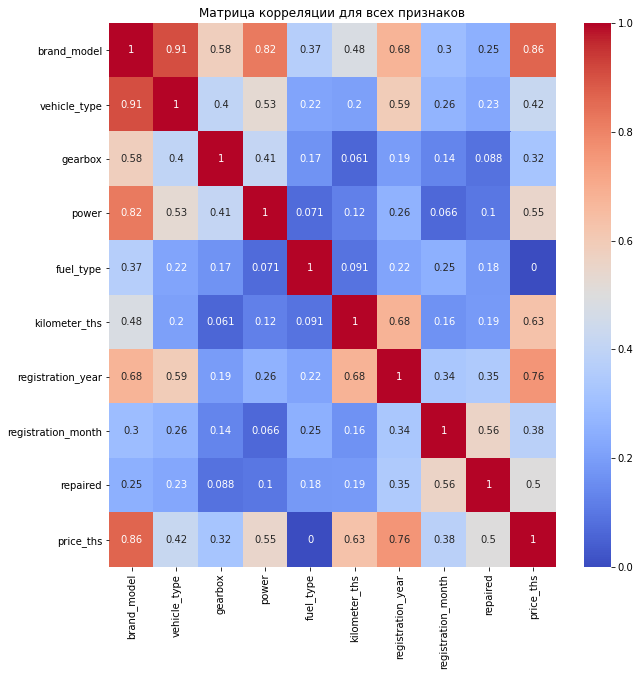

CPU times: user 28.7 s, sys: 932 ms, total: 29.6 s
Wall time: 29.6 s


In [48]:
%%time
#Матрица корреляции со всеми признаками
plt.figure(figsize=(10, 10))
sns.heatmap(autos
    .phik_matrix(interval_cols=[
        'power',
        'kilometer',
        'price']),
        annot=True, 
        cmap='coolwarm')
plt.title('Матрица корреляции для всех признаков')
plt.show();

### Вывод

В ходе корреляционного были сделаны следующие выводы:
- Наблюдается высокая корреляция между признаками `brand_model` и `vehicle_type` (0.91), `brand_model` и `power` (0.84), оставим их как есть;
- У целевого признака `price` наблюдается высокая и заметная корреляция со следующими признаками:
    - `brand_model` (0.77);
    - `power` (0.52);
    - `kilometer_ths` (0.55);
    - `registration_year` (0.73).

## Обучение моделей

### Подготовка данных

Прежде чем обучать модели необходимо подготовить данные, выделив тренировочную, валидационную и тестовую выборки. Примем их размеры следующими:
- Тестовая (60%);
- Валидационная (20%);
- Тестовая (20%).

In [49]:
target = autos['price_ths']
features_df = autos.drop('price_ths', axis=1)

X_train, X_valid_test, y_train, y_valid_test = train_test_split(
    features_df,
    target, 
    train_size=0.6,
    random_state=RANDOM_STATE)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid_test,
    y_valid_test,
    train_size=0.5,
    random_state=RANDOM_STATE)

cat_col_names = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'brand_model']
num_col_names = ['registration_year', 'power', 'kilometer_ths', 'registration_month']

### Кодирование данных

In [50]:
# Кодирование категориальных признаков
ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
X_train_ohe = ohe_encoder.fit_transform(X_train[cat_col_names])
X_valid_ohe = ohe_encoder.transform(X_valid[cat_col_names]) 
X_test_ohe = ohe_encoder.transform(X_test[cat_col_names])
encoder_col_names = ohe_encoder.get_feature_names_out()

# Масштабирование количественных признаков
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_valid_scaled = scaler.transform(X_valid[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

# Создаём датафреймы из кодированных и масштабированных данных
X_train_ohe = X_train_ohe.toarray()
X_valid_ohe = X_valid_ohe.toarray()
X_test_ohe = X_test_ohe.toarray()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_valid_ohe = pd.DataFrame(X_valid_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    
# Объединение датафреймов
X_train_1 = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_valid_1 = pd.concat([X_valid_ohe, X_valid_scaled], axis=1)
X_test_1 = pd.concat([X_test_ohe, X_test_scaled], axis=1)  


### Модель линейной регрессии

#### Разработка модели

In [66]:
%%time

model_lr_1 = LinearRegression()
model_lr_1.fit(X_train_1, y_train);

CPU times: user 2.61 s, sys: 1.22 s, total: 3.84 s
Wall time: 3.81 s


LinearRegression()

In [67]:
%%time
pred_valid = model_lr_1.predict(X_valid_1)
rmse_lr = round(mean_squared_error(y_valid, pred_valid, squared=False), 4)
print(f'RMSE регрессионной модели: {rmse_lr}')

RMSE регрессионной модели: 2.1394
CPU times: user 36.8 ms, sys: 92.2 ms, total: 129 ms
Wall time: 192 ms


#### Вывод

Модель линейной регрессии удовлетворяет необходимому условию: RMSE < 2500€. При этом скорость ее обучения составляет около 3с и скорость предсказания 192 мс.

### Модель деревьев решений

In [53]:
# Создаем пайплайны для подготовки признаков
ohe_pipe= Pipeline(
    [('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, cat_col_names),
    ('num', MinMaxScaler(), num_col_names)],
    remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [54]:
param_grid = [
    #Словарь для модели DecisionTreeRegressor
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

In [55]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True
)

#обучение модели на тренировочной выборке
randomized_search.fit(X_train, y_train);

In [56]:
print(f'Метрика RMSE для лучшей модели: {-round(randomized_search.best_score_, 2)}\n') 
print(f'Лучшая модель и её параметры:\n{randomized_search.best_params_}\n')
res_table = pd.DataFrame(randomized_search.cv_results_)
display(res_table.query('rank_test_score == 1')[['mean_fit_time', 'mean_score_time']] * 1000)

Метрика RMSE для лучшей модели: 1.76

Лучшая модель и её параметры:
{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 5, 'models__min_samples_leaf': 9, 'models': DecisionTreeRegressor(random_state=42)}



,mean_fit_time,mean_score_time
5,997.848368,24.750042


In [57]:
%%time
best_model_dtr = randomized_search.best_estimator_['models']
best_model_dtr_preprocessor = randomized_search.best_estimator_['preprocessor']

X_valid_encoded = best_model_dtr_preprocessor.transform(X_valid)

CPU times: user 55.7 ms, sys: 0 ns, total: 55.7 ms
Wall time: 54.9 ms


In [58]:
%%time

pred_valid = best_model_dtr.predict(X_valid_encoded)
rmse_dtr = round(mean_squared_error(y_valid, pred_valid, squared=False), 4)
print(f'RMSE лучшей модели деревьев решений: {rmse_dtr}')

RMSE лучшей модели деревьев решений: 1.7027
CPU times: user 6.33 ms, sys: 105 µs, total: 6.44 ms
Wall time: 5.19 ms


#### Вывод

Полученная модель удовлетворяет условию качества RMSE < 2500€ (1703). Согласно резульатам лучшей модели, ее среднее время обучения равна 972 мс, а скорость предсказания 23 мс. На валидационной модели скорость предсказания 4.68 мс.

### Модель градиентного бустинга

In [59]:
X_train_3 = X_train.copy()
X_valid_3 = X_valid.copy()
X_test_3 = X_test.copy()

X_train_3[cat_col_names] = X_train_3[cat_col_names].astype('category')
X_valid_3[cat_col_names] = X_valid_3[cat_col_names].astype('category')
X_test_3[cat_col_names] = X_test_3[cat_col_names].astype('category')

#### Модель №1

In [60]:
%%time

model_lgbm_1 = LGBMRegressor(random_state=RANDOM_STATE)
model_lgbm_1.fit(X_train_3, y_train)
pred_valid = model_lgbm_1.predict(X_valid_3)

rmse_lgbm = round(mean_squared_error(y_valid, pred_valid, squared=False), 4)
print(f'RMSE модели градиентного бустинга: {rmse_lgbm}')

RMSE модели градиентного бустинга: 1.4082
CPU times: user 14min 53s, sys: 1.82 s, total: 14min 55s
Wall time: 14min 56s


В качестве гиперпараметров модели LGBM выберем следующие:
- Количество деревьев (n_estimators). Стандартное значение для него 100, выберем следующие значения:
    - 200.
- Глубина деревьев (max_depth). Стандартное значение None, выберем следующие значения:
    - 5;
    - 10.
- Скорость обучения (learning_rate). Стандартное значение 0.1, выберем следующие значения:
    - 0.001;
    - 0.5.

#### Модель №2

In [61]:
%%time

model_lgbm_2 = LGBMRegressor(
    n_estimators = 200,
    random_state=RANDOM_STATE)
model_lgbm_2.fit(X_train_3, y_train)
pred_valid = model_lgbm_2.predict(X_valid_3)

rmse_lgbm = round(mean_squared_error(y_valid, pred_valid, squared=False), 4)
print(f'RMSE модели градиентного бустинга: {rmse_lgbm}')

RMSE модели градиентного бустинга: 1.3903
CPU times: user 4min 9s, sys: 528 ms, total: 4min 9s
Wall time: 4min 10s


#### Модель №3

In [62]:
%%time

model_lgbm_3 = LGBMRegressor(
    n_estimators = 200,
    max_depth=10,
    random_state=RANDOM_STATE)
model_lgbm_3.fit(X_train_3, y_train)
pred_valid = model_lgbm_3.predict(X_valid_3)

rmse_lgbm = round(mean_squared_error(y_valid, pred_valid, squared=False), 4)
print(f'RMSE модели градиентного бустинга: {rmse_lgbm}')

RMSE модели градиентного бустинга: 1.3887
CPU times: user 15.1 s, sys: 43.1 ms, total: 15.1 s
Wall time: 15.1 s


#### Модель №4

In [63]:
%%time

model_lgbm_4 = LGBMRegressor(
    n_estimators = 200,
    max_depth=10,
    learning_rate=0.5,
    random_state=RANDOM_STATE)
model_lgbm_4.fit(X_train_3, y_train)
pred_valid = model_lgbm_4.predict(X_valid_3)

rmse_lgbm = round(mean_squared_error(y_valid, pred_valid, squared=False), 4)
print(f'RMSE модели градиентного бустинга: {rmse_lgbm}')

RMSE модели градиентного бустинга: 1.4437
CPU times: user 9.22 s, sys: 62.7 ms, total: 9.29 s
Wall time: 9.3 s


Уберем параметр max_depth, пусть модель применит лучший вариант.

#### Модель №5

In [64]:
%%time

model_lgbm_5 = LGBMRegressor(
    n_estimators = 200,
    learning_rate=0.5,
    random_state=RANDOM_STATE)
model_lgbm_5.fit(X_train_3, y_train)
pred_valid = model_lgbm_5.predict(X_valid_3)

rmse_lgbm = round(mean_squared_error(y_valid, pred_valid, squared=False), 4)
print(f'RMSE модели градиентного бустинга: {rmse_lgbm}')

RMSE модели градиентного бустинга: 1.4386
CPU times: user 9min 34s, sys: 1.3 s, total: 9min 36s
Wall time: 9min 38s


#### Вывод

В ходе подбора гиперпараметров было выяснено, что наилучшей является третья модель по метрике RMSE (1388€). Результаты по времени рассматривать в данном случае не совсем корректно, поскольку все зависит от выделяемых ресурсов сервера Яндекс.

### Вывод

В ходе разработки моделей машинного обучения были отобраны лучшие со следующими характеристиками:
- Модель линейной регрессии.
    - RMSE составляет 2.139;
    - Время обучения составляет 3.8 с;
    - Время предсказания составялет 192 мс.
- Модель деревьев решений. 
    - Параметры `min_samples_split=6`, `min_samples_leaf=5`;
    - RMSE составялет 1.703;
    - Время обучения составялет 972 мс;
    - Время предсказания составялет 23 мс.
- Модель градиентного бустинга.
    - Параметры `n_estimators = 200`, `max-depth=10`;
    - RMSE модели деревьев решений: 1.388;
    - Время обучения и предсказания составляет 15.1 с.

## Анализ моделей

Итак, мы имеем лучшие модели для предсказания цены автомобилей, все они удовлетворяют условию задания RMSE<2500. Были получены интересные результаты, оказалось, что дерево решений имеет минимальную скорость работы, но при этом обладает средним качеством. Наиболее медленным является модель градиентного бустинга, однако она является самой точной. В качестве рабочей модели выберем модель дерева решений. 

In [69]:
pivot_table = pd.DataFrame()
models = ['LinearRegression()', 
          'DecisionTreeRegressor(models__min_samples_split=6, models__min_samples_leaf=5)', 
          'LGBMRegressor(n_estimators=200, max_depth=10)']
predict_time = [3.992, 0.995, 15.1]
rmse_models = [2.139, 1.703, 1.388]
pivot_table['models'] = models
pivot_table['predict_time_s'] = predict_time
pivot_table['RMSE_models'] = rmse_models

pivot_table

,models,predict_time_s,RMSE_models
0,LinearRegression(),3.992,2.139
1,"DecisionTreeRegressor(models__min_samples_split=6, models__min_samples_leaf=5)",0.995,1.703
2,"LGBMRegressor(n_estimators=200, max_depth=10)",15.100,1.388


In [70]:
%%time

X_test_encoded = best_model_dtr_preprocessor.transform(X_test)

CPU times: user 34.6 ms, sys: 28 µs, total: 34.7 ms
Wall time: 33 ms


In [73]:
%%time

pred_test = best_model_dtr.predict(X_test_encoded)
rmse_dtr_final = round(mean_squared_error(y_test, pred_test, squared=False), 4)
print(f'RMSE лучшей модели: {rmse_dtr_final}')

RMSE лучшей модели: 1.6866
CPU times: user 2.59 ms, sys: 3.74 ms, total: 6.33 ms
Wall time: 4.92 ms


Итак, мы видим, что модель показала хорошие предсказательные результаты, как по метрике RMSE (1686), так и по времени.

## Общий вывод

В ходе проведенного исследования был проделан следующий ряд работ и сделаны следующие выводы:


1. Открыт и изучен файл
    - Датасет `autos`:
        - Всего в датасете 354369 строк и 15 столбцов;
        - Необходимо привести названия к единому стилю;
        - Явные пропуски обнаружены в столбцах:
            - `VehicleType`;
            - `Gearbox`;
            - `Model`;
            - `FuelType`;
            - `Repaired`.
        - Типы данных в столбцах оптимальные;
        - Необходимо проверить данные на дубликаты;
        - Обнаружены явные выбросы в столбцах:
            - `RegistrationYear`;
            - `Power`.
        - В столбце `number_of_pictures` все значения равны 0, поэтому необходимость в данном столбце отпадает, удалим его.
        - Данные являются пригодными для исследования.
    
    
2. Проведена предобработка данных:
     - Названия столбцов приведены к общему стилю;
     - Обработаны пропуски в данных, заменены на `unknown`;
     - Удалены явные дубликаты в данных;
     - Обработаны неявные дубликаты в данных;
     - Обработаны выбросы в данных;
     - Большая часть проблем с данными, вероятно, была вызвана неверным заполнением анкеты:
         - В ней не было обязательных полей;
         - Нет ограничения на некоторые поля, например год;
         - Список вариантов не предлагает варианты выбора, например, модель автомобиля.
        
        
3. Проведен исследовательский анализ данных:
   - Признак `brand`. Наиболее популярными брендами автомобилей являются:
        - Volkswagen;
        - Opel;
        - BMW;
        - Mercedes Benz;
        - Audi.
    - Признак `model`. Наиболее популярными моделями автомобилей являются:
        - golf (Volkswagen);
        - 3er (BMW);
        - astra (Opel).
    - Признак `vehicle_type`. Наиболее популярными типами кузова являются:
        - sedan;
        - wagon;
        - small;
        - bus.
    - Признак `gearbox`. Наиболее популярными КПП являются:
        - Manual (208k);
        - Auto (45k).
    - Пиризнак `power`. Мощность автомобиля равномерно распределена на всем промежутке, и имеет следующие характеристики:
        - Среднее значение - 117 л.с;
        - Медианное значение - 110 л.с;
        - Мода - 75 л.с.
    - Признак `fuel_type`. Наиболее популярными типами топлива являются:
        - Petrol (158k);
        - Gasoline (81k).
    - Признак `kilometer_ths`. Замечено, что наиболее часто встречающимся значением является 150 тыс.км, оно же является максимальным, остальных значений крайне мало.
    - Признак `registration_year`. Большая часть автомобилей зарегистрирована в годы c 1999 по 2007.
    - Признак `registration_month`. Месяцы регистрации распределены равномерно по году.
    - Признак `reapired`. Даже не смотря на то, что неизвестные значения были заменены на наличие ремонта, отстутствие ремонта имеетбольшее число (195 тыс. против 62 тыс.).
    - Признак `price_ths`. Цена автомобиля была приведена к виду тыс. евро. Целевой признак имеет следующие характеристики:
        - Среднее значение - 4.75 тыс. евро;
        - Медианное значение - 3.2 тыс. евро;
        - Максимальное значение - 20 тыс. евро;
        - Такую разницу между средним и медианным значениями можно объяснить наличием выбросов в виде высоких цен, однако мы не можем от них избавиться, потому что это является нормой для данной специфики.
    
    
4. Проведен корреляционный анализ:
    - Наблюдается высокая корреляция между признаками `brand_model` и `vehicle_type` (0.91), `brand_model` и `power` (0.84), оставим их как есть;
    - У целевого признака `price` наблюдается высокая и заметная корреляция со следующими признаками:
        - `brand_model` (0.77);
        - `power` (0.52);
        - `kilometer_ths` (0.55);
        - `registration_year` (0.73).

    
5. Разработаны и обучены модели машинного обучения:
    - Модель линейной регрессии.
        - RMSE составляет 2.139;
        - Время обучения составляет 3.8 с;
        - Время предсказания составялет 192 мс.
    - Модель деревьев решений. 
        - Параметры `min_samples_split=6`, `min_samples_leaf=5`;
        - RMSE составялет 1.703;
        - Время обучения составялет 972 мс;
        - Время предсказания составялет 23 мс.
    - Модель градиентного бустинга.
        - Параметры `n_estimators = 200`, `max-depth=10`;
        - RMSE модели деревьев решений: 1.388;
        - Время обучения и предсказания составляет 15.1 с.

6. Проведен анализ моделей машинного обучения:
    - Условию задания, RMSE < 2500, удовлетворяют все разработанные модели. Наилучший показатель RMSE у модели градиентного бустинга, но поскольку заказчику важна скорость предсказания модели выбираем модель деревьев решений, так как ее время предсказания в несколько раз меньше времени предсказания модели градиентного бустинга.

7. Итоговый вывод:
    - Разработанные модели машиннного обучения показали хорошие результаты и была выбрана наиболее удовлетворяющая условию задачи: модель деревьев принятия решений с параметрами `DecisionTreeRegressor(min_samples_split=5, min_samples_leaf=6)`;
    - Время предсказания данной модели составляет 4.92 мс с погрешностью 1686€;
    - Для улучшения качества предсказания необходимо улучшение сбора данных, поскольку около 30 процентов данных были удалены из выборки из-за пропусков и несоответствия действительности (значение года - 9999). Вероятно, необходимо изменить формуляр анкеты заполнения.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей